# Project 6: High-dynamic range imaging
### Jiamin Shi, Benjamin M. Winger, Jingye Xu


## Abstract

We Implemented Debevec-Malik method of recovering high dynamic range radiance maps from photographs taken with different amounts of exposure. Once radiance maps was computed, we could compress multiple photographs into one low dynamic range gamut by tone mapping. We first demonstrated the algorithm with known exposure time and aligned image, then we dropped the the assumption that exposure time was known. Finally, we extended the method to images taken without tripods using homography-based registration of the sequence.

## Introduction

Modern cameras cannot capture as many details as the human eye can see in any given scene, especially under challenging light conditions. Photographic sensor or film can only capture a range of radiance value that is less than the nature world contains. To recover a full dynamic range image, people can take a set of bracketed exposures photographs. Because the mapping between rediance to pixal value is non-linear and unknonw, the challenge is that how we can combine these images together.

We used Debevec-Malik method to estimate radiometric response function and irradiance value together. Since it is expensive and unnessarly to estimate all pixels, we chose random sampling, uniform sampling and variance-driven sampling and compared their result. Then, we recovered the radiance map by blending pixels from diffrent exposures with the weight function proposed by Mitsunaga and Nayar(1999), which maximized the signal-to-noise ratio. Finally, we use both global mapping and local mapping to display the radiance map on a lower dynamic range.

Even if Debevec-Malik method assume that exposure time is known, we could also estimate exposure time along with radiometric response function by adding constraint terms, as long as we knew the relative relationship of exposure among images. To make our approach more general, we could also pre-process multi-exposure images taken without tripod by homography transform. Furthermore, it is possible to extend it to HDR panorama.

The project is structured as radiometric response function estimation, radiance map recovering, tone mapping and extensions.


## Contributions


|                    |               | 
| -------------------|---------------|
| Jiamin Shi         | 1.1(estimate response function), 1.3, 2.1, abstract&introduction, pipeline integration | 
| Benjamin M. Winger | contri | 
| Jingye Xu          | 1.2, implementation/analysis sample methods | 


## 1. The Algorithm

In [1]:
import numpy as np

import skimage
from skimage import color
from skimage.util import img_as_ubyte

import matplotlib.image as image
import matplotlib.pyplot as plt

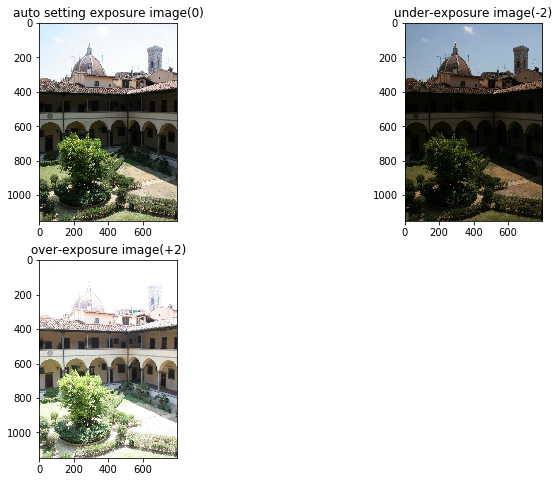

In [2]:
# Load images
# source: https://www.easyhdr.com/examples
im_auto_expose = image.imread("images/laurenziana_0.jpg")
im_under_expose = image.imread("images/laurenziana_-2.jpg")
im_over_expose = image.imread("images/laurenziana_+2.jpg")

imagebracket = np.array([im_under_expose,im_auto_expose,im_over_expose])

log_t = [-2,0,2]

# plot 
plt.figure(figsize = (12, 8))
plt.subplot(221)
plt.imshow(im_auto_expose)
plt.title("auto setting exposure image(0)")
plt.subplot(222)
plt.imshow(im_under_expose)
plt.title("under-exposure image(-2)")
plt.subplot(223)
plt.imshow(im_over_expose)
plt.title("over-exposure image(+2)")
plt.show()



## 1.1  Estimate the radiometric response function from the aligned images

Estimate irradiance values $E_i$ and the radiometric response function $f$ at the same time. 

$$z_{ij} = f(E_i,t_j)$$ where $t_j$ is the exposure time for the $j$th image. 

The inverse response curve $f^{−1}$ is given by
$$f^{−1}(z_{ij}) = E_i t_j$$

Taking logarithms of both sides 
$$g(z_{ij})=\log f^{-1}(z_{ij})=\log E_i +\log t_j$$
 ($g$ maps pixel values $z_{ij}$ into log irradiance)
 


Also, we need make the reponse curve smooth by adding a second-order smoothness constraint
$$\lambda\sum_k g''(k)^2 = \lambda\sum[g(k-1) - 2g(k)+ g(k+1)]^2$$

Since pixel values are more reliable in the middile of their range, they also add a weight function
$$ w(z)=\left\{
\begin{aligned}
z-z_{min} & &  z \le (z_{min}+z_{max})/2 \\
z_{max}-z & & z \gt (z_{min}+z_{max})/2 \\
\end{aligned}
\right.
$$

Put all together we get a least squares problem to estimate the radiometric response function $g$ and irradiance values $E_i$

$$E = \sum_i\sum_jw(z_{i,j})[g(z_{i,j}) - \log E_i - \log t_j]^2 + \lambda\sum_k g''(k)^2$$

In other word, we are solve the two equations 
$$ w(z_{i,j}) g(z_{i,j}) - w(z_{i,j}) \log E_i  = w(z_{i,j}) \log t_j $$ 
$$\lambda[g(z_{i,j}-1) - 2g(z_{i,j})+ g(z_{i,j}+1)] = 0$$
together


#### Assume that $t_j$ is known

The response value $g_k = g(k)$, where g can be discretized according to the 256 pixel values commonly observed in eight-bit images. (The response curves are calibrated separately for each color channel.)

In [3]:
'''
Modified from gsolve.m

Solve for imaging system response function

Given a set of pixel values observed for several pixels in several
images with different exposure times, this function returns the
imaging system’s response function


Z(i,j): the pixel values of pixel location number i in image j

B(j): the log delta t, or log shutter speed, for image j

l: lamdba, the constant that determines the amount of smoothness

w(z): the weighting function value for pixel value z

'''
zmin = 0.
zmax = 255.

def weight_hat(z):
    return min(z-zmin, zmax-z)

def gsolve(Z, B, lmd, w=weight_hat):

    locations = Z.shape[0]
    sequences = Z.shape[1]
    n = 256  # [0, 255]
    A = np.zeros((locations * sequences + n - 1, locations + n), dtype=float)
    b = np.zeros(A.shape[0], dtype=float)

    #  Include the data−fitting equations
    k = 0
    for i in range(locations):
        for j in range(sequences): 
            wij = w(Z[i, j])
            A[k, int(Z[i, j])] = wij
            A[k, n + i] = -wij
            b[k] = wij * B[j]
            k += 1

    # Fix the curve by setting its middle value to 0, i.e. g(128) = 0    
    A[k, 128] = 1   
    k += 1

    # Include the smoothness equations
    for i in range(n-2): #(0, 253) 254 equations
        wi = w(i + 1)
        A[k, i] = lmd * wi
        A[k, i+1] = -2 * lmd * wi
        A[k, i+2] = lmd * wi
        k += 1

    # Solve the system
    x = np.linalg.lstsq(A, b)[0]
    g = x[:n]
    lnE = x[n:]

    return (g, lnE)

In [4]:
# imagepack is to flat each input RGB image into a vector for each channle and pack them into three 2d array
# input: np-array
# return three Z(i,j)(see above) for each channel 
def imagepack(imagearray):
    num_image = imagearray.shape[0]
    # imagesize refer to 1-d image size
    imagesize = imagearray[0].shape[0]*imagearray[0].shape[1]
    imagepack = np.zeros((3, imagesize,num_image))
    # naive loop ; can be optimized later
    for i in range(num_image):
        for j in range(3):
            imagepack[j,:,i] = np.ndarray.flatten(imagearray[i][:,:,j])
    return imagepack
    

In [5]:
RP,GP,BP = imagepack(imagebracket) 

#### Sample

Question: how do we sample the pixel value $z_{ij}$? What is the sample ratio?

The linear system should be overdetermined. For $N$ sample pixels in each image and $P$ images, we need $N \times P > (Z_{max} -Z_{min}) + N$ (i.e. number of given parameters is greater than number of unknowns)

Suppose we have 3 images, $2N > 255$, $N > 128 $ should be sufficient.

$\textbf{Technical Discuss: Weakness/Strength Of Difference Sample Methods}$


For randomSample method - pick pixel randomly

- Weakness: not stable - some random result will lead to very bad estimate, for example, only sampling pixels with intensity 10

- Strength: very quick and if our sample size is big enough, the result will be representative


For windowSample method - pick pixel randomly:

- Weakness: not so stable and having no idea how intensity distributes among the whole images. In some extreme case, it may fail to sample some pixel with certain intensity. Also, as Debevec and Malik 1997 indicated we better avoid highly-variance areas, this schema may visit those bad areas

- Strength: very quick and it also goes through the whole images and in some way, it will be representative. 

For pixelCoverSample method - random select k pixels for each pixel value ([0,255])

- Weakness: slow and have to go through the whole image to know the capacity of the k. Also it require shuffle/couting schema to do randomly sample. Fataly sometimes this schema does not work if any intensity is missing

- Strength: all different intensity pixels get reported. Much more representative









In [6]:
# sample function
# general template:
# inputimg: np.array - like Z(i,j)(see above) ; parameters for different sampling schemas
# output: sampled input


# random chose "outputsize" pixels
def randomSample(inputimg,outputsize):
    outputsize = int(outputsize)
    indexrange = inputimg.shape[0]
    num_image = inputimg.shape[1]
    output = np.zeros((outputsize,num_image))
    sampleindex = np.random.choice(indexrange,size=outputsize,replace=False)
    for i in range(num_image):
        output[:,i] = inputimg[sampleindex,i]
    return output


# choose pixels per windowsize where windowsize = floor(num of pixel / outputsize)
def windowSample(inputimg,outputsize):
    outputsize = int(outputsize)
    indexrange = inputimg.shape[0]
    num_image = inputimg.shape[1]
    windowsize = int(indexrange/outputsize)
    output = np.zeros((outputsize,num_image))
    sampleindex = np.arange(outputsize) * windowsize
    for i in range(num_image):
        output[:,i] = inputimg[sampleindex,i]
    return output

######## warning: 
######## pixelCoverSample is not so good since sometimes, some certain intensity value will be absent
######## for exmaple, int the toy image, we don't have 0 
######## might try some more tolerant sampling schema

# random select k pixels for each pixel value ([0,255])
# base: using which image as a standard to pick index
# if k is too larger, the output will base on the maxmum possible k value
def pixelCoverSample(inputimg,k,base = 1):
    indexrange = inputimg.shape[0]
    num_image = inputimg.shape[1]
    baseimg = inputimg[:,base]
    print(baseimg)
    pixelrange = 256
    # i copy the inputimg since i will call shuffle later, shuffle is a in-place function
    imgcopy = np.copy(inputimg)
    
    # check whether input k is feasible
    freqcount = np.zeros(pixelrange)
    for i in range(indexrange):
        freqcount[int(baseimg[i])] = freqcount[int(baseimg[i])] + 1
    maxk = np.amin(freqcount)
    kval = k if maxk >= k else maxk
    if kval != k:
        print("warning: the given k is more than the capacity!")
    if kval == 0:
        print("warning: the capacity is zero")
        return
    # sample part:
    # i used an inelegant method ; can improve later
    # better idea - store some info while check whther k is feasible
    # Or we can use some buind-in liabary - I did not find yet

    output = np.zeros((kval * pixelrange,num_image))
    # shuffle the imgs so that we have a random behavior
    np.apply_along_axis(np.random.shuffle,1,imgcopy)
    coutmap = np.full((pixelrange*kval),kval)
    # i is the index of imgcopy
    # j is the number of elements we already have in output
    i = 0
    j = 0
    while True:
        if j == pixelrange*kval:
            break
        else:
            tempval = imgcopy[i]
            if coutmap[int(tempval[base])] != 0:
                output[j,:] = imgcopy[i,:]
                coutmap[int(tempval[base])] = coutmap[int(tempval[base])] - 1
                j = j + 1
            i = i + 1
    return output


$\textbf{Extension: variance-driven sampling}$

$\textbf{Idea:}$ 

Debevec and Malik 1997 indicated "Furthermore, the pixels are best sampled from regions of the image with low intensity variance so that radiance can be assumed to be constant across the area of the pixel, and the effect of optical blur of the imaging system is minimized"

In this, we can introduce a biased sample schema that the probablity P of each point $X_{ij}$ get sampled is based on its local gradient


$$W_{i,j} = 1 - sigmoid(||\nabla X_{ij}||)$$

$$p(X_{ij}) = \frac{W_{ij}}{\sum_{p,q}W_{p,q}}$$

In [7]:
# we use sigmoid-like function to map our gradient into probality
# subjective to change
# maybe slow due to floating number
def decreaseSigmoid(a):
    return 1 - 1/(1 + np.exp(-1*a))

vfunc = np.vectorize(decreaseSigmoid)

x = np.matrix( [[1,2],[2,3]])
y = vfunc(x)
y = np.sum(y)

In [8]:
# input:
# imgpack: data from imagePace
# base: choose which image as basis to caculate local variance
# shape: orignal shape
# output:
# 1-d array - the gradient of the image 
def GradientMap(imgpack,shape,base=1):
    baseimg = imgpack[:,base]
    baseimg = baseimg.reshape(shape)
    yGadient = np.gradient(baseimg,axis =0)
    xGadient = np.gradient(baseimg,axis =1)
    result = np.sqrt(yGadient*yGadient + xGadient*xGadient)
    return result

# input: 
# Gradient:data from GradientMap
# functionvector: function vector applying to each pixel in the image; see numpy.vectorize
# output: 
# the weight map for each pixel
def ProbMap(Gradient, functionvector):
    result = functionvector(Gradient)
    result = result / np.sum(result)
    return result


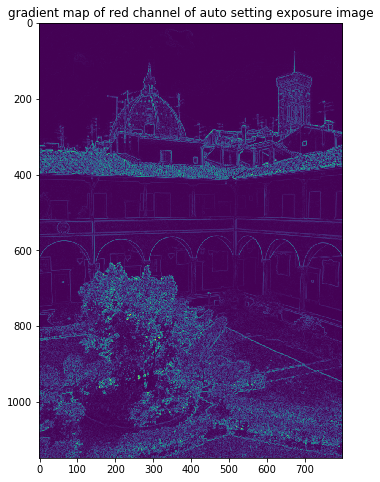

In [9]:
# test block - visualize result 
GradientResult = GradientMap(RP,(im_auto_expose.shape[0],im_auto_expose.shape[1]))

plt.figure(figsize = (12, 8))
plt.title("gradient map of red channel of auto setting exposure image")
plt.imshow(GradientResult)


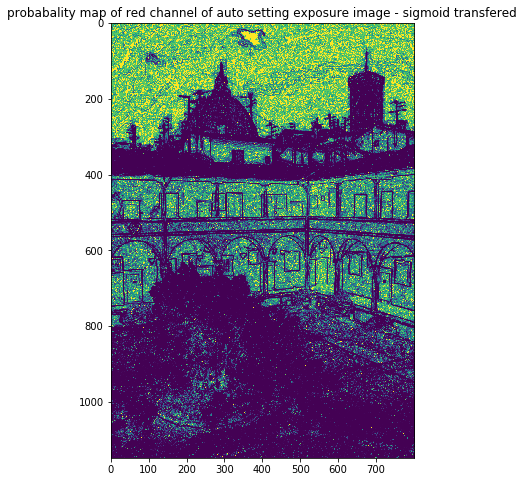

In [10]:
# visualize result 
promap = ProbMap(GradientResult,vfunc)
plt.figure(figsize = (12, 8))
plt.title("probabality map of red channel of auto setting exposure image - sigmoid transfered")
plt.imshow(promap)

In [11]:
#### sampling block
# input:
# imgPack: data from imagePack
# probmap: data from ProbMap
# ouputsize: size of the sample 
# output:
# sampled imagePack
def gradientDrivenSample(imgPack,probmap,outputsize):
    pvector = np.ndarray.flatten(probmap)
    outputsize = int(outputsize)
    indexrange = imgPack.shape[0]
    num_image = imgPack.shape[1]
    output = np.zeros((outputsize,num_image))
    sampleindex = np.random.choice(indexrange,size=outputsize,replace=False,p=pvector)
    for i in range(num_image):
        output[:,i] = imgPack[sampleindex,i]
    return output  

### Print the log response function and result image

If the images are noise free, we can use any non-saturated pixel value to estimate the corresponding radiance by mapping it through the inverse response curve $E = g(z)$.

Debevec and Malik (1997) use a hat function (10.7) which accentuates mid-tone pixels while avoiding saturated values.


In [12]:
%%time
%matplotlib notebook

lmd = 100
#### we use window sample here
targetsize = 1000 #(im_auto_expose.shape[1] * im_auto_expose.shape[0]) / 100
sampledRP = windowSample(RP,targetsize)
sampledGP = windowSample(GP,targetsize)
sampledBP = windowSample(BP,targetsize)
Rg, RinE = gsolve(sampledRP, log_t, lmd)
Gg, GinE = gsolve(sampledGP, log_t, lmd)
Bg, BinE = gsolve(sampledBP, log_t, lmd)


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


CPU times: user 3.59 s, sys: 67.8 ms, total: 3.66 s
Wall time: 2.11 s


In [13]:
%%time
%matplotlib notebook
#### use gradient drive sample schema here

RPpromap = ProbMap(GradientMap(RP,(im_auto_expose.shape[0],im_auto_expose.shape[1])),vfunc)
GPpromap = ProbMap(GradientMap(GP,(im_auto_expose.shape[0],im_auto_expose.shape[1])),vfunc)
BPpromap = ProbMap(GradientMap(BP,(im_auto_expose.shape[0],im_auto_expose.shape[1])),vfunc)


vDsampledRP = gradientDrivenSample(RP,RPpromap,targetsize)
vDsampledGP = gradientDrivenSample(GP,GPpromap,targetsize)
vDsampledBP = gradientDrivenSample(BP,BPpromap,targetsize)

CPU times: user 5.79 s, sys: 169 ms, total: 5.96 s
Wall time: 5.58 s


In [14]:
%%time
%matplotlib notebook
#### we use radient drive sample here
#### notice this can be very slow
vDRg, vDRinE = gsolve(vDsampledRP,[-2,0,2], lmd)
vDGg, vDGinE = gsolve(vDsampledGP,[-2,0,2], lmd)
vDBg, vDBinE = gsolve(vDsampledBP,[-2,0,2], lmd)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


CPU times: user 3.68 s, sys: 73.4 ms, total: 3.76 s
Wall time: 2.57 s


<IPython.core.display.Javascript object>


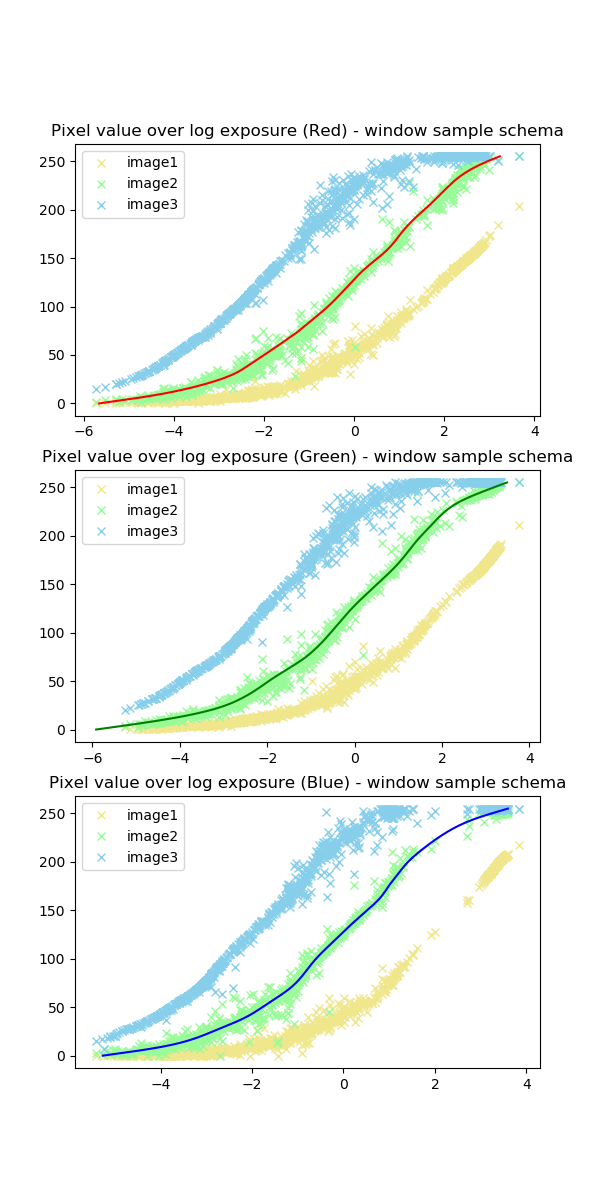

Text(0.5, 1.0, 'Pixel value over log exposure (Blue) - window sample schema')

In [41]:
pixelrange = np.arange(256)

fig = plt.figure(figsize=(6,12))
plt.subplot(311)
plt.plot(RinE, sampledRP[:,0], 'x', color = 'khaki', label='image1')
plt.plot(RinE, sampledRP[:,1], 'x', color = 'palegreen', label='image2')
plt.plot(RinE, sampledRP[:,2], 'x', color = 'skyblue', label='image3')
plt.plot(Rg, pixelrange, color='red')
plt.legend()
plt.title("Pixel value over log exposure (Red) - window sample schema")

plt.subplot(312)
plt.plot(GinE, sampledGP[:,0], 'x', color = 'khaki', label='image1')
plt.plot(GinE, sampledGP[:,1], 'x', color = 'palegreen', label='image2')
plt.plot(GinE, sampledGP[:,2], 'x', color = 'skyblue', label='image3')
plt.plot(Gg, pixelrange, color='green')
plt.legend()
plt.title("Pixel value over log exposure (Green) - window sample schema")

plt.subplot(313)
plt.plot(BinE, sampledBP[:,0], 'x', color = 'khaki', label='image1')
plt.plot(BinE, sampledBP[:,1], 'x', color = 'palegreen', label='image2')
plt.plot(BinE, sampledBP[:,2], 'x', color = 'skyblue', label='image3')
plt.plot(Bg, pixelrange, color='blue')
plt.legend()
plt.title("Pixel value over log exposure (Blue) - window sample schema")



<IPython.core.display.Javascript object>


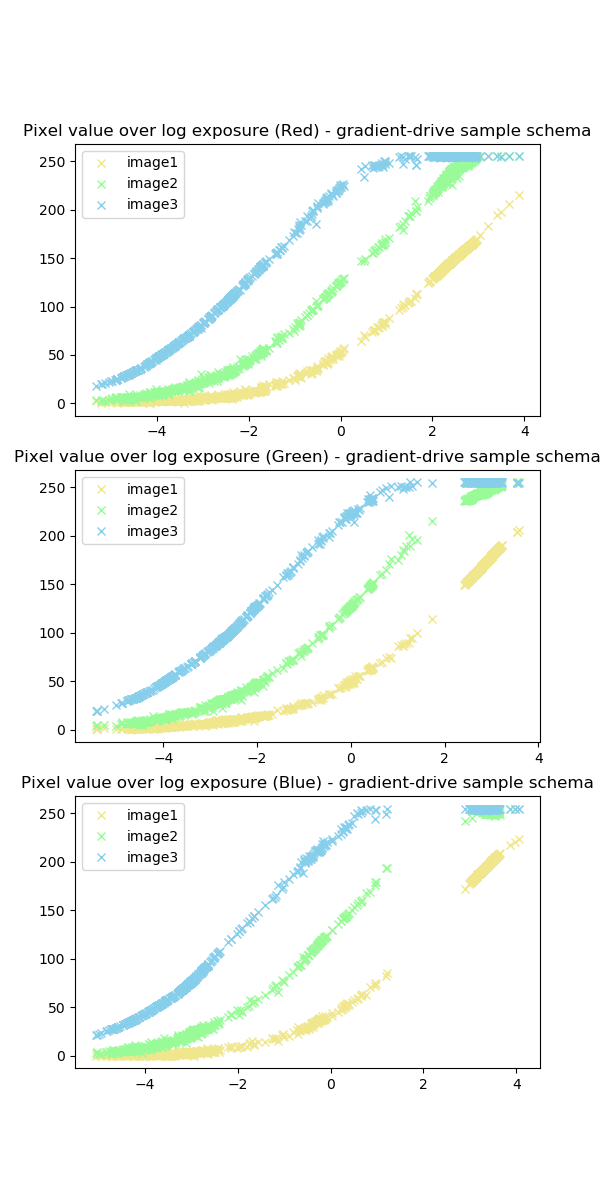

Text(0.5, 1.0, 'Pixel value over log exposure (Blue) - gradient-drive sample schema')

In [42]:
fig = plt.figure(figsize=(6,12))
plt.subplot(311)
plt.plot(vDRinE, vDsampledRP[:,0], 'x', color = 'khaki', label='image1')
plt.plot(vDRinE, vDsampledRP[:,1], 'x', color = 'palegreen', label='image2')
plt.plot(vDRinE, vDsampledRP[:,2], 'x', color = 'skyblue', label='image3')
plt.legend()
plt.title("Pixel value over log exposure (Red) - gradient-drive sample schema")

plt.subplot(312)
plt.plot(vDGinE, vDsampledGP[:,0], 'x', color = 'khaki', label='image1')
plt.plot(vDGinE, vDsampledGP[:,1], 'x', color = 'palegreen', label='image2')
plt.plot(vDGinE, vDsampledGP[:,2], 'x', color = 'skyblue', label='image3')
plt.legend()
plt.title("Pixel value over log exposure (Green) - gradient-drive sample schema")

plt.subplot(313)
plt.plot(vDBinE, vDsampledBP[:,0], 'x', color = 'khaki', label='image1')
plt.plot(vDBinE, vDsampledBP[:,1], 'x', color = 'palegreen', label='image2')
plt.plot(vDBinE, vDsampledBP[:,2], 'x', color = 'skyblue', label='image3')
plt.legend()
plt.title("Pixel value over log exposure (Blue) - gradient-drive sample schema")


In [45]:
### plot block 

plt.figure(4,figsize = (10, 6))
plt.plot(Rg, pixelrange, 'o', color='red')
plt.plot(Gg, pixelrange, 'o', color='green')
plt.plot(Bg, pixelrange, 'o', color='blue')

plt.title("estimated g over pixel - window sample schema")



Text(0.5, 1, 'estimated g over pixel - window sample schema')

In [46]:

pixelrange = np.arange(256)
plt.figure(5,figsize = (12, 8))
plt.plot(vDRg, pixelrange, 'o', color='red')
plt.plot(vDGg, pixelrange, 'o', color='green')
plt.plot(vDBg, pixelrange, 'o', color='blue')
plt.title("estimated g over pixel - gradient-drive sample schema")



Text(0.5, 1, 'estimated g over pixel - gradient-drive sample schema')

## 1.2 Estimate a radiance map by selecting of blending pixels from different exposures

The naive way to measure exposures is

$$\log E_i   = g(z_{ij}) - \log t_j$$

Unfortunately, pixels are noisy, especially under low-light conditions when fewer photons arrive at the sensor. 

Mitsunaga and Nayar (1999) show that in order to maximize the signal-to-noise ratio (SNR), the weighting function must emphasize both higher pixel values and larger gradients in the transfer function
$$
w(z)=f^{-1}(z)/f^{'-1}(z)
$$

(Note that there is some confusion of the notation in the book, the measurement of weight function should based the inverse of reponse function **without logarithm**. Also, weight function should always be **positive**)


the weights $w$ are used to form the final irradiance estimate

$$
\log E_i = \frac{\sum_j w(z_{ij})[g(z_{ij})-\log t_j]}{\sum_j w(z_{ij})}
$$


In [47]:
# input:
# g : the return data from g-solver 
# output:
# result: the weight map
def weightgenerate(g):
    trans = np.exp(g)
    gprime = np.gradient(trans)
    result = np.array(trans/gprime)
    return result

In [48]:
# input:
# g : the return data from g-solver 
# weight: the return data from weightgenerate correspond to g
# t: log shutter speed, for image j
# imgPack: the return data from imagepack
# output:
# logE_i for each pixel - np array
def logEEstimate(g,weight,t,imgPack):
    size = imgPack.shape[0]
    num_img = imgPack.shape[1]
    result = np.zeros(size)
    for i in range(size):
        temp = 0
        weightsum = 0
        for j in range(num_img):
            temp = temp + weight[int(imgPack[i,j])] * (g[int(imgPack[i,j])] - t[j])
            weightsum = weightsum + weight[int(imgPack[i,j])]
        result[i] = temp/weightsum
    return result


In [49]:
%%time
%matplotlib notebook
## estimate g prime g' for each channel
Rweight = weightgenerate(Rg)
Gweight = weightgenerate(Gg)
Bweight = weightgenerate(Bg)
RglogE = logEEstimate(Rg,Rweight,[-2,0,2],RP)
GglogE = logEEstimate(Gg,Gweight,[-2,0,2],GP)
BglogE = logEEstimate(Bg,Bweight,[-2,0,2],BP)

CPU times: user 19.9 s, sys: 272 ms, total: 20.2 s
Wall time: 22.6 s


## 1.3 Tone map the resulting high dynamic range (HDR) image back into a displayable gamut

It is usually necessary to display the HDR image on a lower gamut screen.

1. Global Transfer Curve (i.e Gamma Curve) (Larson, Rushmeier, and Pattanaik 2005)
    - If Gamma curve is applied seperate to each channel, then the color is less saturated 
    - If Gamma curve is applied to the luminance channel, then result is better. (the image is splited up into luminance and chrominance components $L^*a^*b^*$
2. If the image has wide range of exposures, we can divide each pixel by the average brightness in a region around it, like dodging and burning.

### Reconstruct image

In [22]:
result_img = np.zeros(im_auto_expose.shape)
logEs = [RglogE, GglogE, BglogE]
for i in range(3):
    result_img[:,:,i] = (logEs[i].reshape(im_auto_expose.shape[0], im_auto_expose.shape[1]))

In [23]:
def normal2image(img, max_value = 255.):
    ret = img.copy()
    ret -= img.min()
    ret *= max_value / ret.max()
    return ret

def image2normal(img):
    min_value = img.min()
    max_value = img.max()
    normal = (img - img.min()) / (max_value - min_value)
    return normal

#### Linearly maped

In [24]:
img_linearMap = normal2image(result_img).astype(np.uint8)

Gamma correction is, in the simplest cases, defined by the following power-law expression:

$ V_{\text{out}}=A{V_{\text{in}}^{\gamma }}$

where the non-negative real input value $V_{\text{in}}$ is raised to the power $\gamma$  and multiplied by the constant A, to get the output value$V_{\text{out}}$. In the common case of A = 1, inputs and outputs are typically in the range 0–1.

#### Gamma applied to each color channel independentlt

In [25]:
img_normal = image2normal(result_img)

def gamma(Vin, gamma = 0.5):
    return np.power(Vin, 1 / gamma)

img_gamColor = gamma(img_normal)
img_gamColor = normal2image(img_gamColor).astype(np.uint8)

#### Gamma applied to intensity

In [26]:
lab = color.rgb2lab(img_normal)
l_channel = lab[:,:,0]
l_max = l_channel.max()
l_gamma = normal2image(gamma(image2normal(l_channel)), l_max)
lab[:,:,0] = l_gamma
img_gamIntensity = img_as_ubyte(color.lab2rgb(lab))


//anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [27]:
## Dodging and burning (Linear Filters)
lab2 = color.rgb2lab(img_normal)
l_channel = lab2[:,:,0]
hh = np.log(l_channel)
h_low = skimage.filters.gaussian(hh,  sigma=100 , truncate=2.0)
h_high = hh - h_low
h = h_low + h_high * 0.1
l = np.exp(hh)
lab2[:,:,0] = l
img_DaB = img_as_ubyte(color.lab2rgb(lab2))

<IPython.core.display.Javascript object>


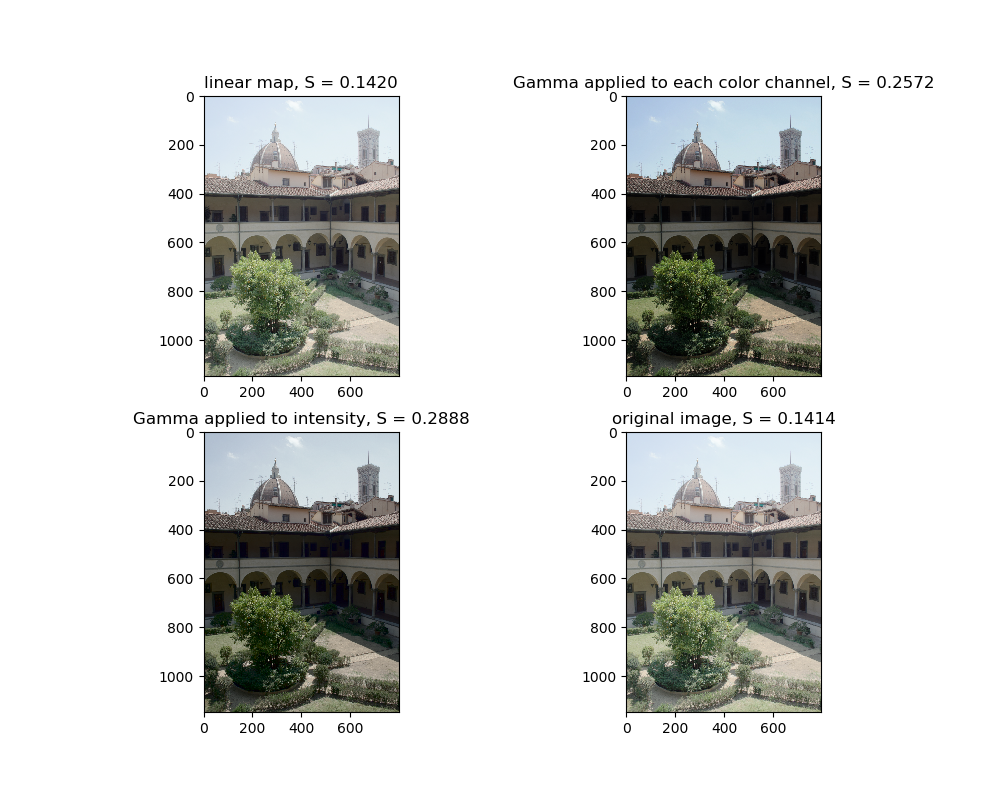

//anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:271: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
//anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:275: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 2. + (arr[idx, 2] - arr[idx, 0]) / delta[idx]
//anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:279: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]


Text(0.5, 1.0, 'original image, S = 0.1414')

In [28]:
def computeSaturation(img):
    return color.rgb2hsv(img)[:,:,1].mean()

fig = plt.figure(figsize=(10,8))
plt.subplot(221)
plt.imshow(img_linearMap)
plt.title('linear map, S = {:.4f}'.format(computeSaturation(img_linearMap)))

plt.subplot(222)
plt.imshow(img_gamColor)
plt.title('Gamma applied to each color channel, S = {:.4f}'.format(computeSaturation(img_gamColor)))

plt.subplot(223)
plt.imshow(img_gamIntensity)
plt.title('Gamma applied to intensity, S = {:.4f}'.format(computeSaturation(img_gamIntensity)))

plt.subplot(224)
plt.imshow(img_DaB)
plt.title('original image, S = {:.4f}'.format(computeSaturation(img_DaB)))

#### Variance-Driven Sample (haven't finished yet)

In [29]:
radiances = [vDRg, vDGg, vDBg]
samples = [RP, GP, BP]
result_img2 = np.zeros(im_auto_expose.shape)

for i in range(len(radiances)):
    weight = weightgenerate(radiances[i])
    result_img2[:,:,i] = (logEEstimate(radiances[i],weight,[-2,0,2],samples[i]).reshape(im_auto_expose.shape[0], im_auto_expose.shape[1]))
    

In [30]:
img_linearMap = normal2image(result_img2).astype(np.uint8)

img_normal = image2normal(result_img2)

img_gamColor = gamma(img_normal)
img_gamColor = normal2image(img_gamColor).astype(np.uint8)

## lab

lab = color.rgb2lab(img_normal)
l_channel = lab[:,:,0]
l_max = l_channel.max()
l_gamma = normal2image(gamma(image2normal(l_channel)), l_max)
lab[:,:,0] = l_gamma
img_gamIntensity = img_as_ubyte(color.lab2rgb(lab))


## 
lab2 = color.rgb2lab(img_normal)
l_channel = lab2[:,:,0]
hh = np.log(l_channel)
h_low = skimage.filters.gaussian(hh,  sigma=100 , truncate=2.0)
h_high = hh - h_low
h = h_low + h_high * 0.1
l = np.exp(hh)
lab2[:,:,0] = l
img_DaB = img_as_ubyte(color.lab2rgb(lab2))

<IPython.core.display.Javascript object>


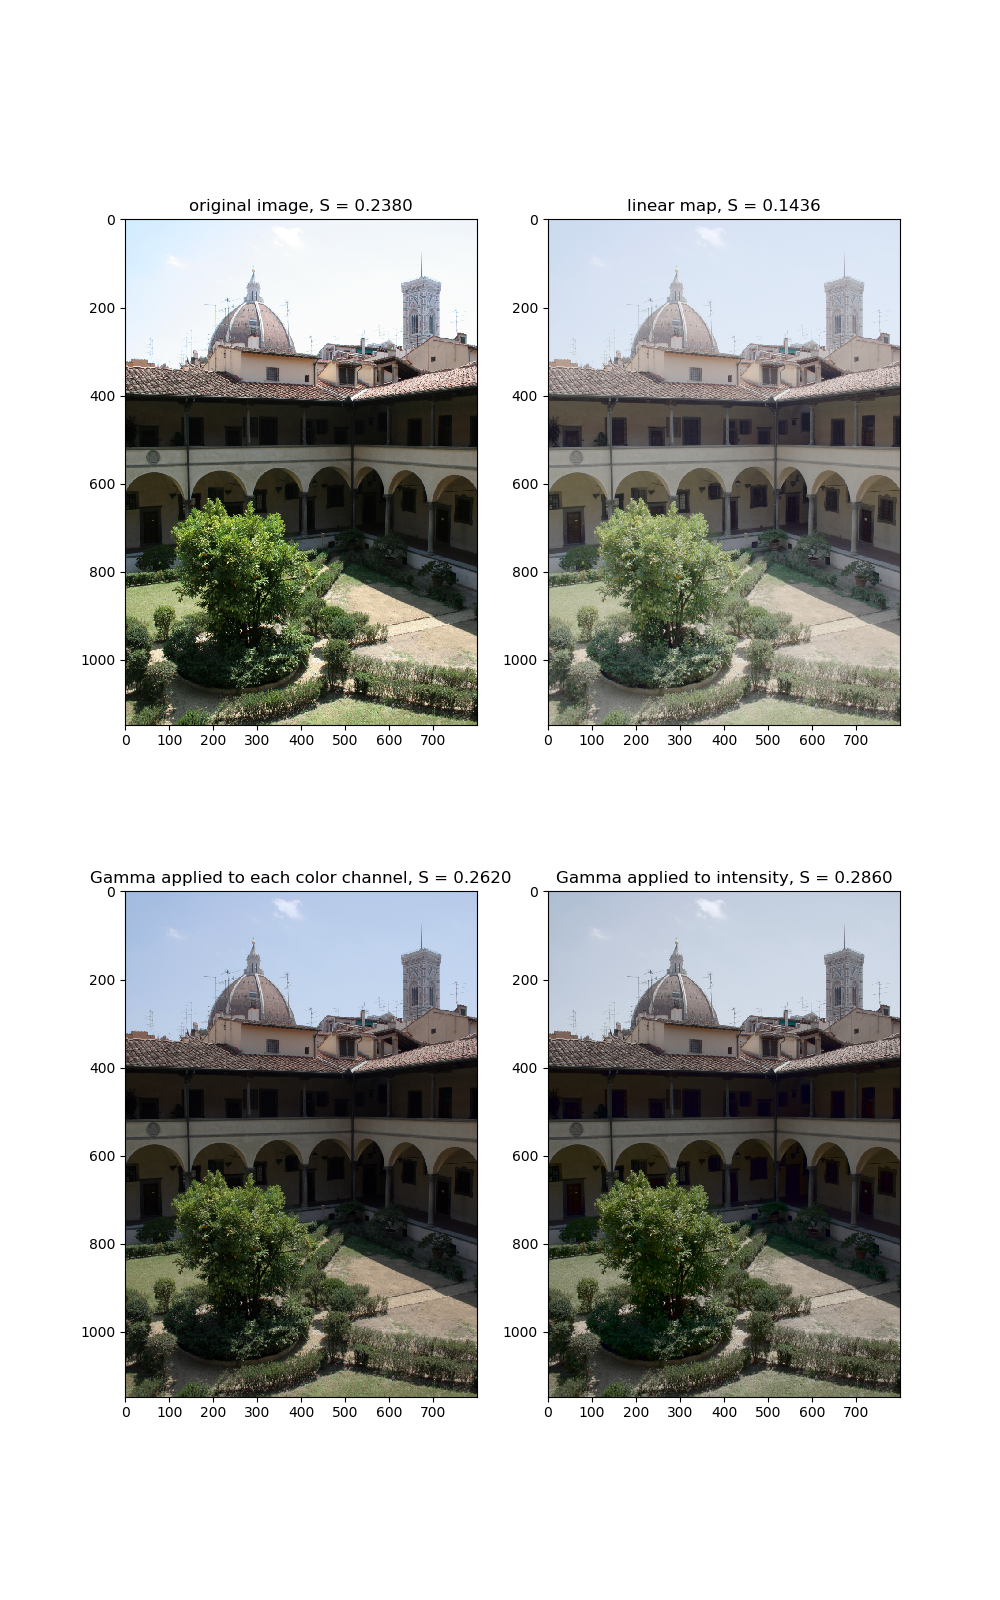

Text(0.5, 1.0, 'original image, S = 0.2380')

In [31]:
fig = plt.figure(figsize=(10,16))
'''
plt.subplot(222)
plt.imshow(img_linearMap)
plt.title('linear map, S = {:.4f}'.format(computeSaturation(img_linearMap)))
'''


plt.subplot(222)
plt.imshow(img_DaB)
plt.title('linear map, S = {:.4f}'.format(computeSaturation(img_DaB)))

plt.subplot(223)
plt.imshow(img_gamColor)
plt.title('Gamma applied to each color channel, S = {:.4f}'.format(computeSaturation(img_gamColor)))

plt.subplot(224)
plt.imshow(img_gamIntensity)
plt.title('Gamma applied to intensity, S = {:.4f}'.format(computeSaturation(img_gamIntensity)))

plt.subplot(221)
plt.imshow(im_auto_expose)
plt.title('original image, S = {:.4f}'.format(computeSaturation(im_auto_expose)))

## 2. Extentions
-  multi-exposure images taken without a tripod using homography-based registration of the sequence
- drop the assumption that exposure is known

(both are metioned in the book)

## 2.1 Drop the assumption that exposure is known

Suppose $\log t_j$ are unknowns in our least squares problem.

$$E = \sum_i\sum_jw(z_{i,j})[g(z_{i,j}) - \log E_i - \log t_j]^2 + \lambda\sum_k g''(k)^2 + \eta \sum_j(t_j - \hat{t}_j)^2$$

In other word, we are solve the three equations together to estimate the radiometric response function $g$, irradiance values $E_i$ and $t_j$
$$ w(z_{i,j}) g(z_{i,j}) - w(z_{i,j}) \log E_i  - w(z_{i,j}) \log t_j= 0 $$ 
$$\lambda[g(z_{i,j}-1) - 2g(z_{i,j})+ g(z_{i,j}+1)] = 0$$
$$ \eta (t_j - \hat{t}_j) = 0$$


In [32]:
'''
Modified from gsolve.m

Solve for imaging system response function

Given a set of pixel values observed for several pixels in several
images with different exposure times, this function returns the
imaging system’s response function


Z(i,j): the pixel values of pixel location number i in image j

l: lamdba, the constant that determines the amount of smoothness

w(z): the weighting function value for pixel value z

eta: the constraint for exposure time, should be positive for ascending exposure time sequence

t_hat: the nominal value of default image (middle image in image sequence)
'''

def gsolve2(Z, lmd, eta = 10, t_hat = 0, w=weight_hat):

    locations = Z.shape[0]
    sequences = Z.shape[1]
    n = 256  # [0, 255]
    A = np.zeros((locations * sequences + n + sequences - 1, n + locations + sequences), dtype=float)
    b = np.zeros(A.shape[0], dtype=float)

    #  Include the data−fitting equations
    k = 0
    for i in range(locations):
        for j in range(sequences): 
            wij = w(Z[i, j])
            A[k, int(Z[i, j])] = wij
            A[k, n + i] = -wij
            A[k, n + locations + j] = -wij #b[k] = wij * B[j]
            k += 1

    # Fix the curve by setting its middle value to 0, i.e. g(128) = 0    
    A[k, 128] = 1   
    k += 1
    
    # Include the smoothness equations
    for i in range(n-2): 
        wi = w(i + 1)
        A[k, i] = lmd * wi
        A[k, i+1] = -2 * lmd * wi
        A[k, i+2] = lmd * wi
        k += 1    
    
    # exposure time constraints
    for i in range(sequences):
        A[k, n + locations + i] = eta 
        b[locations * sequences + n + i - 1] =  eta * (i - sequences//2 + t_hat)
        k += 1
 
    # Solve the system
    x = np.linalg.lstsq(A, b)[0]
    g = x[:n]
    lnE = x[n:n + locations]
    lnt = x[n + locations:]

    return (g, lnE, lnt)

Silimilarly, for $N$ sample pixels in each image and $P$ images, we need $N \times P > (Z_{max} -Z_{min}) + N + P$
Suppose we have 3 images, $2N > 255 + 2$, $N > 129 $ should be sufficient.

In [33]:
lmd = 100

targetsize = 1000
eta = 100
sampledRP = windowSample(RP,targetsize)
sampledGP = windowSample(GP,targetsize)
sampledBP = windowSample(BP,targetsize)
R_g, R_linE, R_lnt = gsolve2(sampledRP, lmd, eta = eta)
G_g, G_linE, G_lnt = gsolve2(sampledRP, lmd, eta = eta)
B_g, B_linE, B_lnt = gsolve2(sampledRP, lmd, eta = eta)


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


<IPython.core.display.Javascript object>


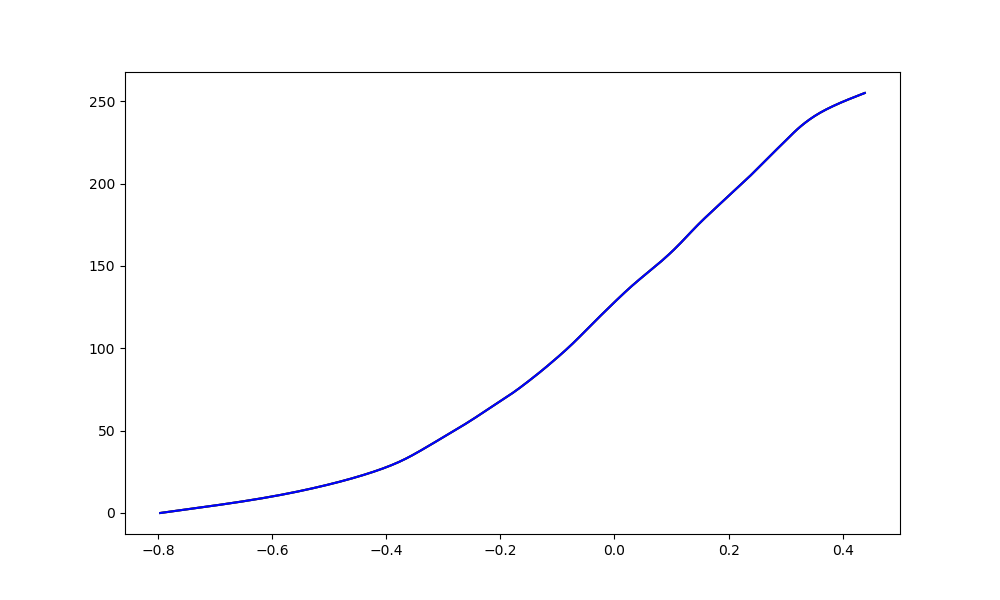

In [34]:
fig = plt.figure(figsize=(10,6))
plt.plot(R_g, np.arange(256), color = "r")
plt.plot(G_g, np.arange(256), color = "g")
plt.plot(B_g, np.arange(256), color = "b")

We will demo our apporoach also works with a longer sequence whose EV is not arithmetic sequence.

In [35]:
cave_prefix = 'images/cave/agia-sofia_'

cave_images = np.array([image.imread(cave_prefix + "-4.0.jpg"),
                       image.imread(cave_prefix + "-2.7.jpg"),
                       image.imread(cave_prefix + "-2.jpg"),
                       image.imread(cave_prefix + "-1.4.jpg"),
                       image.imread(cave_prefix + "-0.7.jpg"),
                       image.imread(cave_prefix + "0.jpg"),
                       image.imread(cave_prefix + "+1.jpg"),
                       image.imread(cave_prefix + "+2.jpg"),
                       image.imread(cave_prefix + "+3.jpg"),
                       image.imread(cave_prefix + "+4.jpg"),
                       image.imread(cave_prefix + "+5.jpg")])

In [36]:
cave_RP,cave_GP,cave_BP = imagepack(cave_images) 

lmd = 100
eta = 10

cave_sampledRP = windowSample(cave_RP, 100)
cave_sampledGP = windowSample(cave_GP, 100)
cave_sampledBP = windowSample(cave_BP, 100)
cave_R_g, cave_R_linE, cave_R_lnt = gsolve2(cave_sampledRP, lmd, eta = eta)
cave_G_g, cave_G_linE, cave_G_lnt = gsolve2(cave_sampledGP, lmd, eta = eta)
cave_B_g, cave_B_linE, cave_B_lnt = gsolve2(cave_sampledBP, lmd, eta = eta)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


<IPython.core.display.Javascript object>


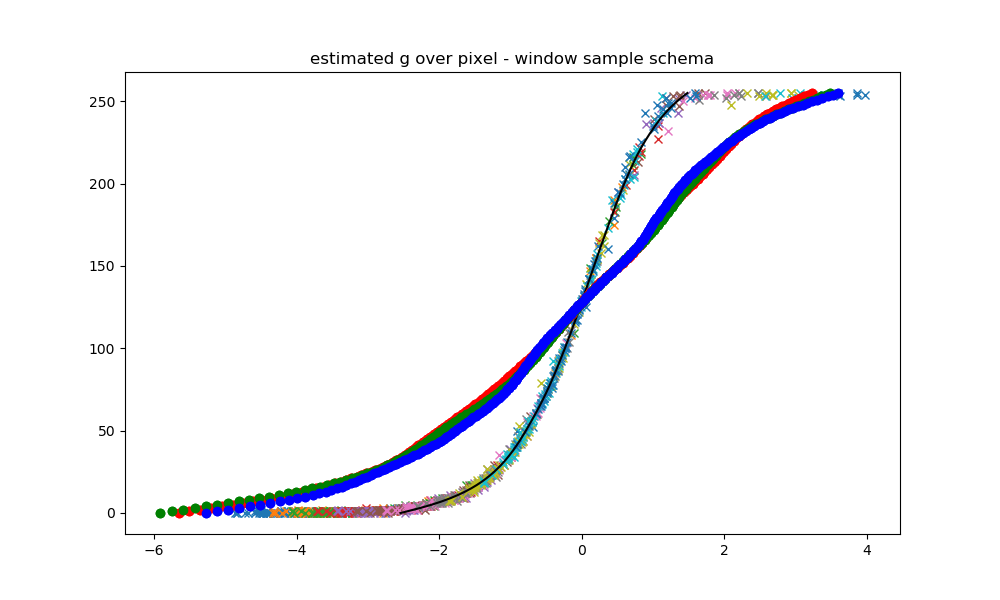

Text(0.5, 1.0, 'Pixel value over log exposure (Red)')

In [37]:
fig = plt.figure(figsize=(10,6))

for i in range(cave_images.shape[0]):
    plt.plot(cave_R_linE + cave_R_lnt[i], cave_sampledRP[:,i], 'x')
    
plt.plot(cave_R_g, np.arange(256), color = 'black')
plt.title('Pixel value over log exposure (Red)')

In [38]:
cave_lnt = np.sum([cave_R_lnt, cave_G_lnt, cave_B_lnt], axis = 0) / 3.0
print("The estimated lnt are")
print(cave_lnt)

The estimated lnt are
[-1.85865633 -1.34581373 -1.07812468 -0.72715786 -0.43679806 -0.14849442
  0.26910842  0.69284299  1.12451205  1.54950445  1.95907716]


In [39]:
cave_R_weight = weightgenerate(cave_R_g)
cave_G_weight = weightgenerate(cave_G_g)
cave_B_weight = weightgenerate(cave_B_g)
cave_RglogE = logEEstimate(cave_R_g,cave_R_weight,cave_lnt,cave_RP)
cave_GglogE = logEEstimate(cave_G_g,cave_G_weight,cave_lnt,cave_GP)
cave_BglogE = logEEstimate(cave_B_g,cave_B_weight,cave_lnt,cave_BP)

cave_result_img = np.zeros(cave_images[0].shape)
cave_logEs = [cave_RglogE, cave_GglogE, cave_BglogE]
for i in range(3):
    cave_result_img[:,:,i] = (cave_logEs[i].reshape(cave_result_img.shape[0], cave_result_img.shape[1]))

<IPython.core.display.Javascript object>


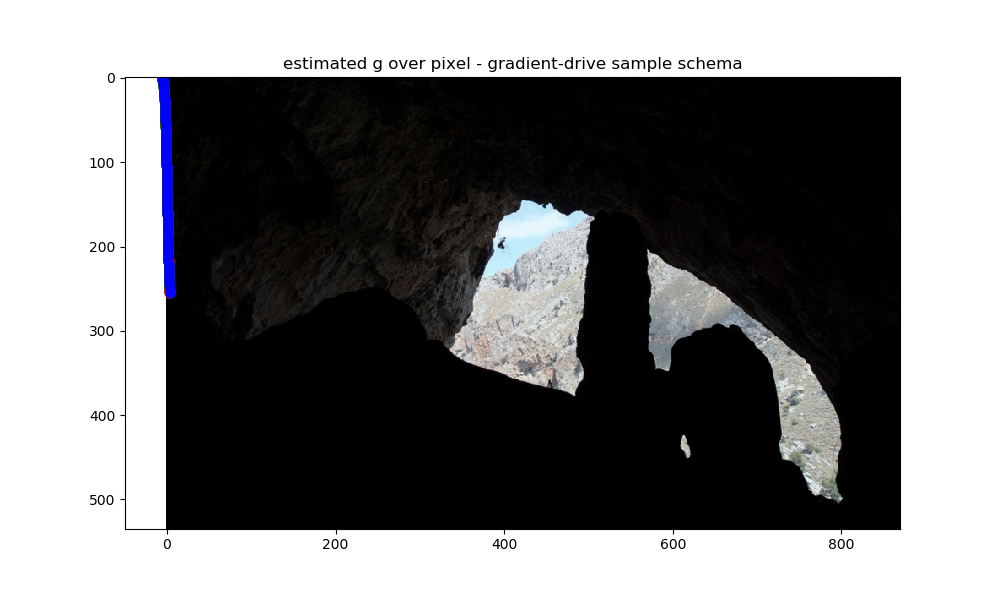

Text(0.5, 1.0, 'Image recovered with unknown exposure time')

In [40]:
cave_img_linearMap = normal2image(cave_result_img).astype(np.uint8)
cave_img_normal = image2normal(cave_result_img)
cave_img_gamColor = normal2image(gamma(cave_img_normal, 0.3)).astype(np.uint8)
fig = plt.figure(figsize=(10,6))
plt.imshow(cave_img_gamColor)
plt.title("Image recovered with unknown exposure time")

## Conclusions 
(2-4 paragraphs) summarizing your observations, results, etc.